In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [4]:
from google.colab import files
uploaded = files.upload()


Saving archive (3).zip to archive (3).zip


In [7]:
import zipfile

with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("data_folder")


In [8]:
import os

# List files in the extracted folder
for root, dirs, files in os.walk("data_folder"):
    for file in files:
        print(os.path.join(root, file))


data_folder/online_retail_II.csv


In [10]:
import pandas as pd

df = pd.read_csv("data_folder/customers.csv")
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [11]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0


In [12]:
X = df.iloc[:, [3, 4]].values


In [13]:
# Select only numeric columns for clustering

df = df.dropna()   # remove rows with missing values

numeric_df = df.select_dtypes(include=['int64', 'float64'])

numeric_df.head()



,Quantity,Price,Customer ID
0,12,6.95,13085.0
1,12,6.75,13085.0
2,12,6.75,13085.0
3,48,2.10,13085.0
4,24,1.25,13085.0


In [14]:
# Creating a new feature: Total Amount Spent by each transaction
numeric_df['Total_Spend'] = numeric_df['Quantity'] * numeric_df['Price']

# We only need the meaningful features for clustering
X = numeric_df[['Quantity', 'Total_Spend']]

# Scaling data for better clustering performance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]   # preview


array([[-0.00219379,  0.20475475],
       [-0.00219379,  0.19697983],
       [-0.00219379,  0.19697983],
       [ 0.1883066 ,  0.26112293],
       [ 0.06130634,  0.03176276]])

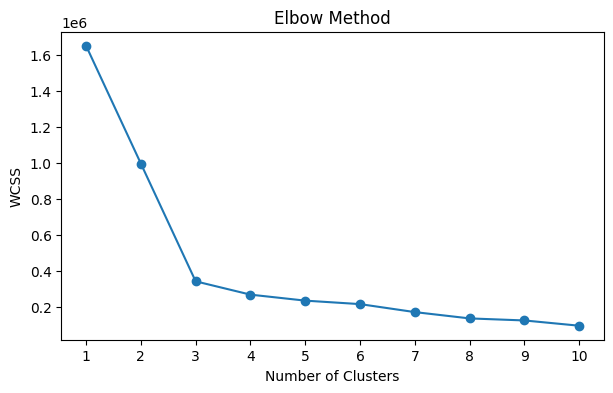

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# assume wcss already computed
x_vals = list(range(1, len(wcss) + 1))

plt.figure(figsize=(7,4))
plt.plot(x_vals, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.xticks(x_vals)
plt.show()

In [16]:
from sklearn.cluster import KMeans

k = 4   # change this to what you observed in elbow method

kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster labels back to the original dataframe
df['Cluster'] = clusters

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,0
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,0


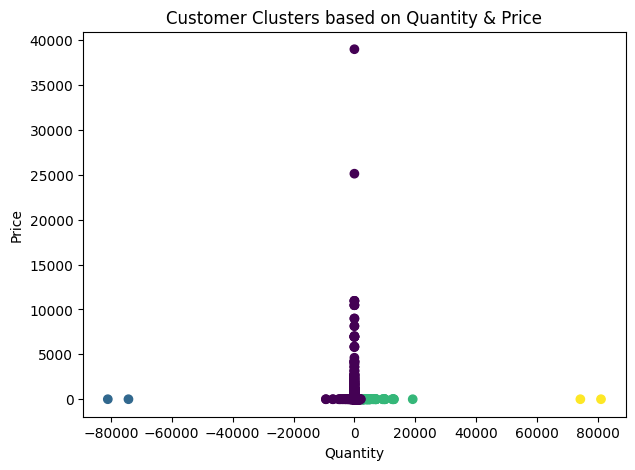

In [17]:
plt.figure(figsize=(7,5))
plt.scatter(df['Quantity'], df['Price'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Customer Clusters based on Quantity & Price')
plt.show()


In [20]:
# Select only numeric columns + Cluster for analysis
numeric_cols = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
cluster_summary = numeric_cols.groupby(df['Cluster']).mean().round(2)

print("=== Cluster Summary (Mean values) ===")
display(cluster_summary)

# Interpreting clusters based on Quantity and Price
print("\n=== Cluster Meaning ===")
for i in range(len(cluster_summary)):
    qty = cluster_summary.iloc[i]['Quantity']
    price = cluster_summary.iloc[i]['Price']

    if qty < 20 and price < 5:
        print(f"Cluster {i}: 🟢 Low Quantity, Low Price → Budget / Casual Buyers")
    elif qty > 40 and price > 10:
        print(f"Cluster {i}: 🔴 High Quantity, High Price → Premium / Bulk Buyers")
    elif qty < 20 and price > 10:
        print(f"Cluster {i}: 🟡 Low Quantity, High Price → Occasional Luxury Buyers")
    elif qty > 40 and price < 5:
        print(f"Cluster {i}: 🔵 High Quantity, Low Price → Wholesale or Discount Buyers")
    else:
        print(f"Cluster {i}: ⚪ Moderate Quantity & Price → Regular Customers")


=== Cluster Summary (Mean values) ===


,Quantity,Price,Customer ID,Cluster
Cluster,,,,
0,11.80,3.68,15324.70,0.0
1,-77605.00,1.56,14396.00,1.0
2,4978.04,6.72,14880.71,2.0
3,77605.00,1.56,14396.00,3.0



=== Cluster Meaning ===
Cluster 0: 🟢 Low Quantity, Low Price → Budget / Casual Buyers
Cluster 1: 🟢 Low Quantity, Low Price → Budget / Casual Buyers
Cluster 2: ⚪ Moderate Quantity & Price → Regular Customers
Cluster 3: 🔵 High Quantity, Low Price → Wholesale or Discount Buyers


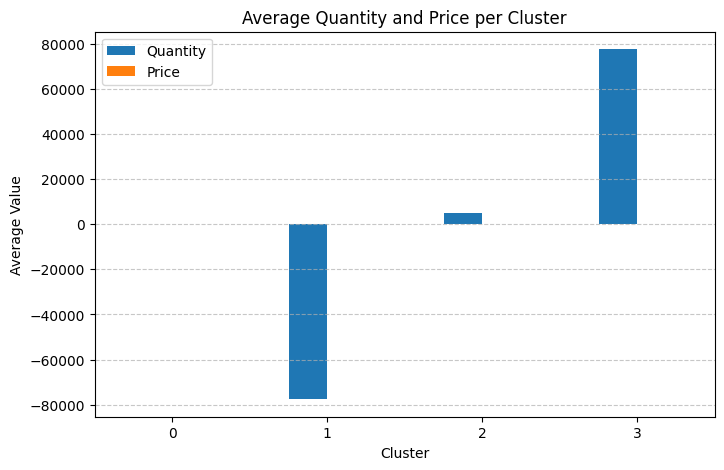

In [21]:
import matplotlib.pyplot as plt

# Plot cluster summary (average Quantity and Price per cluster)
cluster_summary[['Quantity', 'Price']].plot(
    kind='bar',
    figsize=(8,5),
    title='Average Quantity and Price per Cluster',
    xlabel='Cluster',
    ylabel='Average Value',
    legend=True
)

plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [24]:
print("📈 Business Insights:")
print("- Cluster 0: Budget Buyers — Low quantity & low spending, need discounts.")
print("- Cluster 1: Premium Buyers — High value customers, target with loyalty rewards.")
print("- Cluster 2: Occasional Shoppers — Spend high occasionally, use seasonal offers.")
print("- Cluster 3: Wholesale Buyers — Buy in bulk, focus on B2B deals.")


📈 Business Insights:
- Cluster 0: Budget Buyers — Low quantity & low spending, need discounts.
- Cluster 1: Premium Buyers — High value customers, target with loyalty rewards.
- Cluster 2: Occasional Shoppers — Spend high occasionally, use seasonal offers.
- Cluster 3: Wholesale Buyers — Buy in bulk, focus on B2B deals.


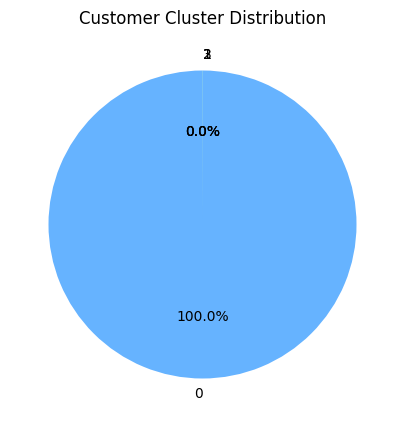

In [22]:
# Pie chart for cluster distribution
df['Cluster'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    figsize=(5,5),
    colors=['#66b3ff','#99ff99','#ffcc99','#ff9999']
)

plt.title('Customer Cluster Distribution')
plt.ylabel('')
plt.show()
